<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/IRC007.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/wannasmile/colab_code_note/refs/heads/main/Acard.txt

--2025-02-05 16:18:33--  https://raw.githubusercontent.com/wannasmile/colab_code_note/refs/heads/main/Acard.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19693447 (19M) [text/plain]
Saving to: ‘Acard.txt’

Acard.txt           100%[===================>]  18.78M   124MB/s    in 0.2s    

2025-02-05 16:18:34 (124 MB/s) - ‘Acard.txt’ saved [19693447/19693447]



In [2]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
enc.fit([[0, 0, 3],
    [1, 1, 0],
    [0, 2, 1],
    [1, 0, 2]])

ans = enc.transform([[0, 1, 3]]).toarray()
# 如果不加 toarray() 的话，输出的是稀疏的存储格式，即索引加值的形式，也可以通过参数指定 sparse = False 来达到同样的效果
print(ans) # 输出 [[ 1.  0.  0.  1.  0.  0.  0.  0.  1.]]

[[1. 0. 0. 1. 0. 0. 0. 0. 1.]]


下面解释输出结果的意思。对于输入数组，这依旧是把每一行当作一个样本，每一列当作一个特征。


我们先来看第一个特征，即第一列 [0,1,0,1]，也就是说它有两个取值 0 或者 1，那么 one-hot 就会使用两位来表示这个特征，[1,0] 表示 0， [0,1] 表示 1，在上例输出结果中的前两位 [1,0...] 也就是表示该特征为 0。

第二个特征，第二列 [0,1,2,0]，它有三种值，那么 one-hot 就会使用三位来表示这个特征，[1,0,0] 表示 0， [0,1,0] 表示 1，[0,0,1] 表示 2，在上例输出结果中的第三位到第五位 [...0,1,0...] 也就是表示该特征为 1。


第三个特征，第三列 [3,0,1,2]，它有四种值，那么 one-hot 就会使用四位来表示这个特征，[1,0,0,0] 表示 0， [0,1,0,0] 表示 1，[0,0,1,0] 表示 2，[0,0,0,1] 表示 3，在上例输出结果中的最后四位 [...0,0,0,1] 也就是表示该特征为 3。

好了，到此相信我们已经很明白它的意思了。值得注意的是，虽然训练样本中的数值仅仅代表类别，但是也必须使用数值格式的数据，如果使用字符串格式的数据会报错。




In [3]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
enc.transform([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]]).toarray()

array([[1., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 1., 1., 0., 0., 0., 0., 1., 0.]])

In [4]:
from sklearn.preprocessing import OneHotEncoder

import math
#离散型变量 WOE编码
class charWoe(object):
    def __init__(self, datasets, dep, weight, vars):
        #数据集字典，{'dev':训练集,'val':测试集,'off':跨时间验证集}
        self.datasets = datasets
        self.devf = datasets.get("dev", "") #训练集
        self.valf = datasets.get("val", "") #测试集
        self.offf = datasets.get("off", "") #跨时间验证集
        self.dep = dep #标签
        self.weight = weight #样本权重
        self.vars = vars #参与建模的特征名
        self.nrows, self.ncols = self.devf.shape #样本数，特征数

    def char_woe(self):
        #得到每一类样本的个数，且加入平滑项使得bad和good都不为0
        dic = dict(self.devf.groupby([self.dep]).size())
        good = dic.get(0, 0) + 1e-10
        bad = dic.get(1, 0) + 1e-10
        #对每一个特征进行遍历
        for col in self.vars:
            #得到每一个特征值对应的样本数
            data = dict(self.devf[[col, self.dep]].groupby([col, self.dep]).size())
            '''
            当前特征取值超过100个的时候，跳过当前取值。
            因为取值过多时，WOE分箱的效率较低，建议对特征进行截断。
            出现频率过低的特征值统一赋值，放入同一箱内。
            '''
            if len(data) > 100:
                print(col, "contains too many different values...")
                continue
            #打印取值个数
            print(col, len(data))
            dic = dict()
            #k是特征名和特征取值的组合，v是样本数
            for (k, v) in data.items():
                #value为特征名，dp为特征取值
                value, dp = k
                #如果找不到key设置为一个空字典
                dic.setdefault(value, {})
                #字典中嵌套字典
                dic[value][int(dp)] = v
            for (k, v) in dic.items():
                dic[k] = {str(int(k1)): v1 for (k1, v1) in v.items()}
                dic[k]["cnt"] = sum(v.values())
                bad_rate = round(v.get("1", 0) / dic[k]["cnt"], 5)
                dic[k]["bad_rate"] = bad_rate
            #利用定义的函数进行合并
            dic = self.combine_box_char(dic)
            #对每个特征计算WOE值和IV值
            for (k, v) in dic.items():
                a = v.get("0", 1) / good + 1e-10
                b = v.get("1", 1) / bad + 1e-10
                dic[k]["Good"] = v.get("0", 0)
                dic[k]["Bad"] = v.get("1", 0)
                dic[k]["woe"] = round(math.log(a / b), 5)
            '''
            按照分箱后的点进行分割，
            计算得到每一个特征值的WOE值，
            将原始特征名加上'_woe'后缀，并赋予WOE值。
            '''
            for (klis, v) in dic.items():
                for k in klis.split(","):
                    #训练集进行替换
                    self.devf.loc[self.devf[col]==k, "%s_woe" % col] = v["woe"]
                    #测试集进行替换
                    if not isinstance(self.valf, str):
                        self.valf.loc[self.valf[col]==k, "%s_woe" % col] = v["woe"]
                    #跨时间验证集进行替换
                    if not isinstance(self.offf, str):
                        self.offf.loc[self.offf[col]==k, "%s_woe" % col] = v["woe"]
        #返回新的字典，其中包含三个数据集
        return {"dev": self.devf, "val": self.valf, "off": self.offf}

    def combine_box_char(self, dic):
        '''
        实施两种分箱策略。
        1.不同箱之间负样本占比差异最大化。
        2.每一箱的样本量不能过少。
        '''
        #首先合并至10箱以内，按照每一箱负样本占比差异最大化原则进行分箱
        while len(dic) >= 10:
            #k是特征值，v["bad_rate"]是特征值对应的负样本占比
            bad_rate_dic = {k: v["bad_rate"] for (k, v) in dic.items()}
            #按照负样本占比排序。
            #因为离散型变量是无序的，可以直接写成负样本占比递增的形式
            bad_rate_sorted = sorted(bad_rate_dic.items(), key=lambda x: x[1])
            #计算每两箱之间的负样本占比差值，准备将差值最小的两箱进行合并
            bad_rate = [bad_rate_sorted[i+1][1]-bad_rate_sorted[i][1] for i in range(len(bad_rate_sorted)-1)]
            min_rate_index = bad_rate.index(min(bad_rate))
            #k1和k2是差值最小的两箱的key
            k1, k2 = bad_rate_sorted[min_rate_index][0], bad_rate_sorted[min_rate_index+1][0]
            #得到重新划分后的字典，箱的个数比之前少一
            dic["%s,%s" % (k1, k2)] = dict()
            dic["%s,%s" % (k1, k2)]["0"] = dic[k1].get("0", 0) + dic[k2].get("0", 0)
            dic["%s,%s" % (k1, k2)]["1"] = dic[k1].get("1", 0) + dic[k2].get("1", 0)
            dic["%s,%s" % (k1, k2)]["cnt"] = dic[k1]["cnt"] + dic[k2]["cnt"]
            dic["%s,%s" % (k1, k2)]["bad_rate"] = round(dic["%s,%s" % (k1, k2)]["1"] / dic["%s,%s" % (k1, k2)]["cnt"], 5)
            #删除旧的key
            del dic[k1], dic[k2]
        '''
        结束循环后，箱的个数应该少于10。
        下面实施第二种分箱策略。
        将样本数量少的箱合并至其他箱中，以保证每一箱的样本数量不要太少。
        '''
        #记录当前样本最少的箱的个数
        min_cnt = min([v["cnt"] for v in dic.values()])
        #当样本数量小于总样本的5%或者总箱的个数大于5的时候，对箱进行合并
        while min_cnt < self.nrows * 0.05 and len(dic) > 5:
            min_key = [k for (k, v) in dic.items() if v["cnt"] == min_cnt][0]
            bad_rate_dic = {k: v["bad_rate"] for (k, v) in dic.items()}
            bad_rate_sorted = sorted(bad_rate_dic.items(), key=lambda x: x[1])
            keys = [k[0] for k in bad_rate_sorted]
            min_index = keys.index(min_key)
            '''''
            同样想保持合并后箱之间的负样本占比差异最大化。
            由于箱的位置不同，按照三种不同情况进行分类讨论。
            '''
            #如果是第一箱，和第二项合并
            if min_index == 0:
                k1, k2 = keys[:2]
            #如果是最后一箱，和倒数第二箱合并
            elif min_index == len(dic) - 1:
                k1, k2 = keys[-2:]
            #如果是中间箱，和bad_rate值相差最小的箱合并
            else:
                bef_bad_rate = dic[min_key]["bad_rate"] - dic[keys[min_index - 1]]["bad_rate"]
                aft_bad_rate = dic[keys[min_index+1]]["bad_rate"] - dic[min_key]["bad_rate"]
                if bef_bad_rate < aft_bad_rate:
                    k1, k2 = keys[min_index - 1], min_key
                else:
                    k1, k2 = min_key, keys[min_index + 1]
            #得到重新划分后的字典，箱的个数比之前少一
            dic["%s,%s" % (k1, k2)] = dict()
            dic["%s,%s" % (k1, k2)]["0"] = dic[k1].get("0", 0) + dic[k2].get("0", 0)
            dic["%s,%s" % (k1, k2)]["1"] = dic[k1].get("1", 0) + dic[k2].get("1", 0)
            dic["%s,%s" % (k1, k2)]["cnt"] = dic[k1]["cnt"] + dic[k2]["cnt"]
            dic["%s,%s" % (k1, k2)]["bad_rate"] = round(dic["%s,%s" % (k1, k2)]["1"] / dic["%s,%s" % (k1, k2)]["cnt"], 5)
            #删除旧的key
            del dic[k1], dic[k2]
            #当前最小的箱的样本个数
            min_cnt = min([v["cnt"] for v in dic.values()])
        return dic

In [5]:
import math

def sloveKS(self, model, X, Y, Weight):
    Y_predict = [s[1] for s in model.predict_proba(X)]
    nrows = X.shape[0]
    #还原权重
    lis = [(Y_predict[i], Y.values[i], Weight[i]) for i in range(nrows)]
    #按照预测概率倒序排列
    ks_lis = sorted(lis, key=lambda x: x[0], reverse=True)
    KS = list()
    bad = sum([w for (p, y, w) in ks_lis if y > 0.5])
    good = sum([w for (p, y, w) in ks_lis if y <= 0.5])
    bad_cnt, good_cnt = 0, 0
    for (p, y, w) in ks_lis:
        if y > 0.5:
            #1*w 即加权样本个数
            bad_cnt += w
        else:
            #1*w 即加权样本个数
            good_cnt += w
        ks = math.fabs((bad_cnt/bad)-(good_cnt/good))
        KS.append(ks)
    return max(KS)

def slovePSI(self, model, dev_x, val_x):
    dev_predict_y = [s[1] for s in model.predict_proba(dev_x)]
    dev_nrows = dev_x.shape[0]
    dev_predict_y.sort()
    #等频分箱成10份
    cutpoint = [-100] + [dev_predict_y[int(dev_nrows/10*i)] for i in range(1, 10)] + [100]
    cutpoint = list(set(cutpoint))
    cutpoint.sort()
    val_predict_y = [s[1] for s in list(model.predict_proba(val_x))]
    val_nrows = val_x.shape[0]
    PSI = 0
    #每一箱之间分别计算PSI
    for i in range(len(cutpoint)-1):
        start_point, end_point = cutpoint[i], cutpoint[i+1]
        dev_cnt = [p for p in dev_predict_y if start_point <= p < end_point]
        dev_ratio = len(dev_cnt) / dev_nrows + 1e-10
        val_cnt = [p for p in val_predict_y if start_point <= p < end_point]
        val_ratio = len(val_cnt) / val_nrows + 1e-10
        psi = (dev_ratio - val_ratio) * math.log(dev_ratio / val_ratio)
        PSI += psi
    return PSI

import xgboost as xgb
from xgboost import plot_importance

class xgBoost(object):
    def __init__(self, datasets, uid, dep, weight, var_names, params, max_del_var_nums=0):
        self.datasets = datasets
        #样本唯一标识，不参与建模
        self.uid = uid
        #二分类标签
        self.dep = dep
        #样本权重
        self.weight = weight
        #特征列表
        self.var_names = var_names
        #参数字典，未指定字段使用默认值
        self.params = params
        #单次迭代最多删除特征的个数
        self.max_del_var_nums = max_del_var_nums
        self.row_num = 0
        self.col_num = 0

    def training(self, min_score=0.0001, modelfile="", output_scores=list()):
        lis = self.var_names[:]
        dev_data = self.datasets.get("dev", "")  #训练集
        val_data = self.datasets.get("val", "")  #测试集
        off_data = self.datasets.get("off", "")  #跨时间验证集
        #从字典中查找参数值，没有则使用第二项作为默认值
        model = xgb.XGBClassifier(
              learning_rate=self.params.get("learning_rate", 0.1),
              n_estimators=self.params.get("n_estimators", 100),
              max_depth=self.params.get("max_depth", 3),
              min_child_weight=self.params.get("min_child_weight", 1),
              subsample=self.params.get("subsample", 1),
              objective=self.params.get("objective", "binary:logistic"),
              nthread=self.params.get("nthread", 10),
              scale_pos_weight=self.params.get("scale_pos_weight", 1),
              random_state=0,
              n_jobs=self.params.get("n_jobs", 10),
              reg_lambda=self.params.get("reg_lambda", 1),
              missing=self.params.get("missing", None) )
        while len(lis) > 0:
            #模型训练
            model.fit(X=dev_data[self.var_names], y=dev_data[self.dep])
            #得到特征重要性
            scores = model.feature_importances_
            #清空字典
            lis.clear()
            '''
            当特征重要性小于预设值时，将特征放入待删除列表。
            当列表长度超过预设最大值时，跳出循环。
            即一次只删除限定个数的特征。
            '''
            for (idx, var_name) in enumerate(self.var_names):
                #小于特征重要性预设值则放入列表
                if scores[idx] < min_score:
                    lis.append(var_name)
                #达到预设单次最大特征删除个数则停止本次循环
                if len(lis) >= self.max_del_var_nums:
                    break
            #训练集KS
            devks = self.sloveKS(model, dev_data[self.var_names], dev_data[self.dep], dev_data[self.weight])
            #初始化KS和PSI
            valks, offks, valpsi, offpsi = 0.0, 0.0, 0.0, 0.0
            #测试集KS和PSI
            if not isinstance(val_data, str):
                valks = self.sloveKS(model,
                            val_data[self.var_names],
                            val_data[self.dep],
                            val_data[self.weight])
                valpsi = self.slovePSI(model,
                            dev_data[self.var_names],
                            val_data[self.var_names])
            #跨时间验证集KS和PSI
            if not isinstance(off_data, str):
                offks = self.sloveKS(model,
                            off_data[self.var_names],
                            off_data[self.dep],
                            off_data[self.weight])
                offpsi = self.slovePSI(model,
                            dev_data[self.var_names],
                            off_data[self.var_names])
            #将三个数据集的KS和PSI放入字典
            dic = {"devks": float(devks),
                 "valks": float(valks),
                 "offks": offks,
                 "valpsi": float(valpsi),
                 "offpsi": offpsi}
            print("del var: ", len(self.var_names),
                "-->", len(self.var_names) - len(lis),
                "ks: ", dic, ",".join(lis))
            self.var_names = [var_name for var_name in self.var_names if var_name not in lis]
        plot_importance(model)
        #重新训练，准备进入下一循环
        model = xgb.XGBClassifier(
               learning_rate=self.params.get("learning_rate", 0.1),
               n_estimators=self.params.get("n_estimators", 100),
               max_depth=self.params.get("max_depth", 3),
               min_child_weight=self.params.get("min_child_weight", 1),
               subsample=self.params.get("subsample", 1),
               objective=self.params.get("objective", "binary:logistic"),
               nthread=self.params.get("nthread", 10),
               scale_pos_weight=self.params.get("scale_pos_weight", 1),
               random_state=0,
               n_jobs=self.params.get("n_jobs", 10),
               reg_lambda=self.params.get("reg_lambda", 1),
               missing=self.params.get("missing", None))










In [6]:
def target_value(self, old_devks, old_offks, target, devks, offks, w=0.2):
    '''
    如果参数设置为"best"，使用最优调参策略，
    否则使用跨时间测试集KS最大策略。
    '''
    if target == "best":
        return offks-abs(devks-offks) * w
    else:
        return offks

def check_params(self, dev_data, off_data, params, param, train_number, step, target, targetks, old_devks, old_offks):
    '''
    当前向搜索对调参策略有提升时，
    继续前向搜索，
    否则进行后向搜索。
    '''
    while True:
        try:
            if params[param] + step > 0:
                params[param] += step
                model = xgb.XGBClassifier(max_depth=params.get("max_depth", 3),
                                learning_rate=params.get("learning_rate", 0.05),
                                n_estimators=params.get("n_estimators", 100),
                                min_child_weight=params.get("min_child_weight", 1),
                                subsample=params.get("subsample", 1),
                                scale_pos_weight=params.get("scale_pos_weight", 1),
                                nthread=10,
                                n_jobs=10,
                                random_state=0)

                model.fit(dev_data[self.var_names],
                      dev_data[self.dep],
                      dev_data[self.weight])

                devks = self.sloveKS(model,
                            dev_data[self.var_names],
                            dev_data[self.dep],
                            dev_data[self.weight])
                offks = self.sloveKS(model,
                            off_data[self.var_names],
                            off_data[self.dep],
                            off_data[self.weight])
                train_number += 1
                targetks_n = self.target_value(old_devks=old_devks,
                                  old_offks=old_offks,
                                  target=target,
                                  devks=devks,
                                  offks=offks)
                if targetks < targetks_n:
                    targetks = targetks_n
                    old_devks = devks
                    old_offks = offks
                else:
                    break
            else:
                break
        except:
            break
    params[param] -= step
    return params, targetks, train_number

def auto_choose_params(self, target="offks"):
    """
    "mzh1": offks + (offks - devks) * 0.2 最大化
    "mzh2": (offks + (offks - devks) * 0.2)**2 最大化
    其余取值均使用跨时间测试集offks 最大化
    当业务稳定性较差时，应将0.2改为更大的值
    """
    dev_data = self.datasets.get("dev", "")
    off_data = self.datasets.get("off", "")
    #设置参数初始位置
    params = {
        "max_depth": 5,
        "learning_rate": 0.09,
        "n_estimators": 120,
        "min_child_weight": 50,
        "subsample": 1,
        "scale_pos_weight": 1,
        "reg_lambda": 21
    }
    model = xgb.XGBClassifier(max_depth=params.get("max_depth", 3),
                    learning_rate=params.get("learning_rate", 0.05),
                    n_estimators=params.get("n_estimators", 100),
                    min_child_weight=params.get("min_child_weight", 1),
                    subsample=params.get("subsample", 1),
                    scale_pos_weight=params.get("scale_pos_weight", 1),
                    reg_lambda=params.get("reg_lambda", 1),
                    nthread=8,
                    n_jobs=8,
                    random_state=7)

    model.fit(dev_data[self.var_names],
          dev_data[self.dep],
          dev_data[self.weight])
    devks = self.sloveKS(model,
                dev_data[self.var_names],
                dev_data[self.dep],
                dev_data[self.weight])
    offks = self.sloveKS(model,
                off_data[self.var_names],
                off_data[self.dep],
                off_data[self.weight])
    train_number = 0
    #设置调参步长
    dic = {
        "learning_rate": [0.05, -0.05],
        "max_depth": [1, -1],
        "n_estimators": [20, 5, -5, -20],
        "min_child_weight": [20, 5, -5, -20],
        "subsample": [0.05, -0.05],
        "scale_pos_weight": [20, 5, -5, -20],
        "reg_lambda": [10, -10]
    }
    #启用调参策略
    targetks = self.target_value(old_devks=devks,
                      old_offks=offks, target=target,
                      devks=devks, offks=offks)
    old_devks = devks
    old_offks = offks
    #按照参数字典，双向搜索最优参数
    while True:
        targetks_lis = []
        for (key, values) in dic.items():
            for v in values:
                if v + params[key] > 0:
                    params, targetks, train_number = \
                            self.check_params(dev_data,
                                      off_data, params,
                                      key, train_number,
                                      v, target, targetks,
                                      old_devks, old_offks)
                    targetks_n = self.target_value(old_devks=old_devks,
                                      old_offks=old_offks,
                                      target=target,
                                      devks=devks, offks=offks)
                    if targetks < targetks_n:
                        old_devks = devks
                        old_offks = offks
                        targetks_lis.append(targetks)
        if not targetks_lis:
            break
    print("Best params: ", params)
    model = xgb.XGBClassifier(max_depth=params.get("max_depth", 3),
                    learning_rate=params.get("learning_rate", 0.05),
                    n_estimators=params.get("n_estimators", 100),
                    min_child_weight=params.get("min_child_weight", 1),
                    subsample=params.get("subsample", 1),
                    scale_pos_weight=params.get("scale_pos_weight", 1),
                    reg_lambda=params.get("reg_lambda", 1),
                    nthread=10, n_jobs=10, random_state=0)
    model.fit(dev_data[self.var_names], dev_data[self.dep], dev_data[self.weight])


In [7]:
# -*- coding: utf-8 -*-

def auto_delete_vars(self):
    dev_data = self.datasets.get("dev", "")
    off_data = self.datasets.get("off", "")
    params = self.params
    model = xgb.XGBClassifier(max_depth=params.get("max_depth", 3),
                    learning_rate=params.get("learning_rate", 0.05),
                    n_estimators=params.get("n_estimators", 100),
                    min_child_weight=params.get("min_child_weight", 1),
                    subsample=params.get("subsample", 1),
                    scale_pos_weight=params.get("scale_pos_weight", 1),
                    reg_lambda=params.get("reg_lambda", 1),
                    nthread=8, n_jobs=8, random_state=7)
    model.fit(dev_data[self.var_names], dev_data[self.dep], dev_data[self.weight])
    offks = self.sloveKS(model, off_data[self.var_names], off_data[self.dep], off_data[self.weight])
    train_number = 0
    print("train_number: %s, offks: %s" % (train_number, offks))
    del_list = list()
    oldks = offks
    while True:
        bad_ind = True
        for var_name in self.var_names:
            #遍历每一个特征
            model=xgb.XGBClassifier(max_depth=params.get("max_depth", 3),
                          learning_rate=params.get("learning_rate", 0.05),
                          n_estimators=params.get("n_estimators", 100),
                          min_child_weight=params.get("min_child_weight", 1),
                          subsample=params.get("subsample", 1),
                          scale_pos_weight=params.get("scale_pos_weight", 1),
                          reg_lambda=params.get("reg_lambda", 1),
                          nthread=10, n_jobs=10, random_state=7)
            #将当前特征从模型中去掉
            names = [var for var in self.var_names if var_name != var]
            model.fit(dev_data[names], dev_data[self.dep], dev_data[self.weight])
            train_number += 1
            offks = self.sloveKS(model, off_data[names], off_data[self.dep], off_data[self.weight])
            '''
            比较KS是否有提升，
            如果有提升或者武明显变化，
            则可以将特征去掉。
            '''
            if offks >= oldks:
                oldks = offks
                bad_ind = False
                del_list.append(var_name)
                self.var_names = names
            else:
                continue
        if bad_ind:
            break
    print("(End) train_n: %s, offks: %s del_list_vars: %s" % (train_number, offks, del_list))


In [8]:
!pip install pyecharts
!pip install pylab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.7/153.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 6.4 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement pylab (from versions: none)
ERROR: No matching distribution found for pylab


In [9]:
!apt-get -y update
!apt-get -y install fonts-liberation
!apt-get -y install -f
!apt-get -y install fonts-wqy-zenhei

# Download SimHei font
!wget -O /usr/share/fonts/truetype/liberation/simhei.ttf "https://raw.githubusercontent.com/StellarCN/scp_zh/refs/heads/master/fonts/SimHei.ttf"
!wget -O simhei.ttf "https://raw.githubusercontent.com/StellarCN/scp_zh/refs/heads/master/fonts/SimHei.ttf"


# Import font_manager after clearing the cache
import matplotlib.font_manager as fm
import matplotlib
matplotlib.font_manager.fontManager.addfont('simhei.ttf')
matplotlib.rc('font', family='SimHei')

# Set font family
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,606 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,657 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,230 kB]
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,650 kB]
Hit:13 https://ppa.launchpadcontent.net/graphics-driver

一开始对数值型变量进行WOE映射，主要是为了弱化极值影响、增加模型鲁棒，但是树模型对极值和变量分布波动并不敏感。



train_ks :  0.4488490257066827
val_ks :  0.41967251573199565


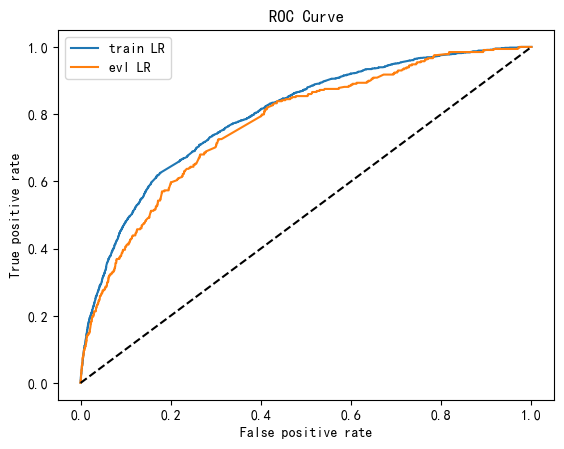

       KS  负样本个数  正样本个数  负样本累计个数  正样本累计个数    捕获率  负样本占比
0   0.217     86    713       86      713  0.262  0.108
1   0.299     43    756      129     1469  0.393  0.054
2   0.339     29    770      158     2239  0.482  0.036
3   0.381     30    769      188     3008  0.573  0.038
4   0.398     22    777      210     3785  0.640  0.028
5   0.403     18    781      228     4566  0.695  0.023
6   0.408     18    781      246     5347  0.750  0.023
7   0.398     13    786      259     6133  0.790  0.016
8   0.396     16    783      275     6916  0.838  0.020
9   0.361      5    794      280     7710  0.854  0.006
10  0.332      7    792      287     8502  0.875  0.009
11  0.287      2    797      289     9299  0.881  0.003
12  0.258      7    792      296    10091  0.902  0.009
13  0.225      6    793      302    10884  0.921  0.008
14  0.205     10    789      312    11673  0.951  0.013
15  0.182      9    790      321    12463  0.979  0.011
16  0.137      2    797      323    13260  0.985

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:20:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "boosting_type", "enable_categorical", "missing", "n_estimators", "num_leaves", "subsample_freq" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	train-auc:0.71706	eval-auc:0.68662
[2]	train-auc:0.77844	eval-auc:0.74047
[3]	train-auc:0.77699	eval-auc:0.73386
[4]	train-auc:0.77700	eval-auc:0.73390
[5]	train-auc:0.79648	eval-auc:0.75562
[6]	train-auc:0.79734	eval-auc:0.76376
[7]	train-auc:0.79948	eval-auc:0.77002
[8]	train-auc:0.79872	eval-auc:0.76597
[9]	train-auc:0.79851	eval-auc:0.77083
[10]	train-auc:0.80137	eval-auc:0.77379
[11]	train-auc:0.80057	eval-auc:0.77482
[12]	train-auc:0.79833	eval-auc:0.77607
[13]	train-auc:0.79753	eval-auc:0.77661
[14]	train-auc:0.79765	eval-auc:0.77817
[15]	train-auc:0.79860	eval-auc:0.77641
[16]	train-auc:0.79788	eval-auc:0.77680
[17]	train-auc:0.79670	eval-auc:0.77664
[18]	train-auc:0.79502	eval-auc:0.77529
[19]	train-auc:0.79601	eval-auc:0.77683
[20]	train-auc:0.79591	eval-auc:0.77773
[21]	train-auc:0.79992	eval-auc:0.78027
[22]	train-auc:0.79752	eval-auc:0.77980
[23]	train-auc:0.79882	eval-auc:0.77988
[24]	train-auc:0.79998	eval-auc:0.77966
[25]	train-auc:0.80119	eval-auc:0.78075
[26]	trai

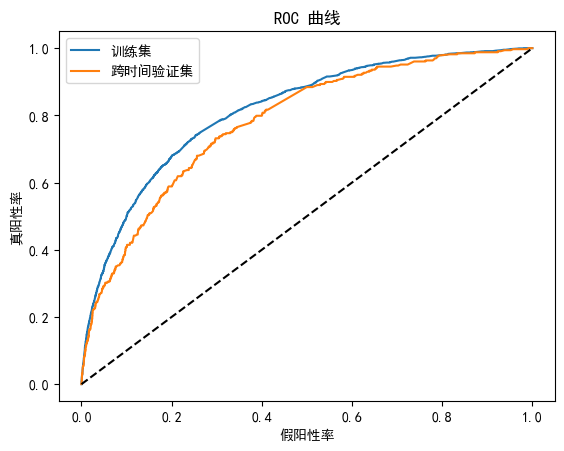

       KS  BAD  GOOD  BAD_CNT  GOOD_CNT  BAD_PCTG  BADRATE
0   0.045    2   797        2       797     0.006    0.003
1   0.090    2   797        4      1594     0.012    0.003
2   0.138    1   798        5      2392     0.015    0.001
3   0.182    2   797        7      3189     0.021    0.003
4   0.215    6   793       13      3982     0.040    0.008
5   0.253    4   795       17      4777     0.052    0.005
6   0.292    4   795       21      5572     0.064    0.005
7   0.321    7   792       28      6364     0.085    0.009
8   0.357    5   794       33      7158     0.101    0.006
9   0.386    7   792       40      7950     0.122    0.009
10  0.391   15   784       55      8734     0.168    0.019
11  0.407   11   788       66      9522     0.201    0.014
12  0.421   12   787       78     10309     0.238    0.015
13  0.425   15   784       93     11093     0.284    0.019
14  0.402   24   775      117     11868     0.357    0.030
15  0.394   19   780      136     12648     0.415    0.0

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:723: FutureWarning: Pass `evals, obj, feval` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:20:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:0.26490	eval-error:0.03953	train-rmse:0.26082	train-error:0.03816
[1]	eval-rmse:0.13947	eval-error:0.01381	train-rmse:0.13173	train-error:0.01227
[2]	eval-rmse:0.23131	eval-error:0.02900	train-rmse:0.23120	train-error:0.02884
[3]	eval-rmse:0.38546	eval-error:0.07614	train-rmse:0.38989	train-error:0.07766
[4]	eval-rmse:0.53893	eval-error:0.14707	train-rmse:0.54629	train-error:0.15087
[5]	eval-rmse:0.68506	eval-error:0.23650	train-rmse:0.69517	train-error:0.24329
[6]	eval-rmse:0.82403	eval-error:0.34136	train-rmse:0.83670	train-error:0.35169
[7]	eval-rmse:0.95655	eval-error:0.45934	train-rmse:0.97174	train-error:0.47379
[8]	eval-rmse:1.08336	eval-error:0.58869	train-rmse:1.10112	train-error:0.60789
[9]	eval-rmse:1.20523	eval-error:0.72814	train-rmse:1.22554	train-error:0.75263
[10]	eval-rmse:1.32263	eval-error:0.87653	train-rmse:1.34569	train-error:0.90710
[11]	eval-rmse:1.43626	eval-error:1.03328	train-rmse:1.46202	train-error:1.07040
[12]	eval-rmse:1.54630	eval-error:1.19

In [10]:
import pandas as pd  # 导入 pandas 用于数据处理
from sklearn.metrics import roc_auc_score, roc_curve, auc  # 导入 sklearn.metrics 用于模型评估
from sklearn import metrics  # 导入 sklearn.metrics 用于模型评估
from sklearn.linear_model import LogisticRegression  # 导入 LogisticRegression 用于模型训练
import numpy as np  # 导入 numpy 用于数值计算

# 读取数据
data = pd.read_csv('Acard.txt')
data.head()  # 显示数据前几行
data.obs_mth.unique()  # 查看 obs_mth 列的唯一值

# 划分训练集和验证集
train = data[data.obs_mth != '2018-11-30'].reset_index().copy()  # obs_mth 不等于 '2018-11-30' 的数据作为训练集
val = data[data.obs_mth == '2018-11-30'].reset_index().copy()  # obs_mth 等于 '2018-11-30' 的数据作为验证集

# 定义特征列表
feature_lst = ['person_info', 'finance_info', 'credit_info', 'act_info']

# 提取训练集和验证集的特征和目标变量
x = train[feature_lst]  # 训练集特征
y = train['bad_ind']  # 训练集目标变量

val_x = val[feature_lst]  # 验证集特征
val_y = val['bad_ind']  # 验证集目标变量

# 创建并训练逻辑回归模型
lr_model = LogisticRegression(C=0.1, class_weight='balanced')  # 创建模型，设置正则化参数和类别权重
lr_model.fit(x, y)  # 训练模型

# 训练集预测和 KS 计算
y_pred = lr_model.predict_proba(x)[:, 1]  # 预测训练集样本的坏账概率
fpr_lr_train, tpr_lr_train, _ = roc_curve(y, y_pred)  # 计算 ROC 曲线
train_ks = abs(fpr_lr_train - tpr_lr_train).max()  # 计算 KS 值
print('train_ks : ', train_ks)

# 验证集预测和 KS 计算
y_pred = lr_model.predict_proba(val_x)[:, 1]  # 预测验证集样本的坏账概率
fpr_lr, tpr_lr, _ = roc_curve(val_y, y_pred)  # 计算 ROC 曲线
val_ks = abs(fpr_lr - tpr_lr).max()  # 计算 KS 值
print('val_ks : ', val_ks)

# 绘制 ROC 曲线
from matplotlib import pyplot as plt  # 导入 pyplot 用于绘图

plt.plot(fpr_lr_train, tpr_lr_train, label='train LR')  # 绘制训练集 ROC 曲线
plt.plot(fpr_lr, tpr_lr, label='evl LR')  # 绘制验证集 ROC 曲线
plt.plot([0, 1], [0, 1], 'k--')  # 绘制对角线
plt.xlabel('False positive rate')  # 设置 x 轴标签
plt.ylabel('True positive rate')  # 设置 y 轴标签
plt.title('ROC Curve')  # 设置图表标题
plt.legend(loc='best')  # 显示图例
plt.show()  # 显示图表





import math  # 导入 math 模块用于数学计算

# 使用训练好的逻辑回归模型
model = lr_model
row_num, col_num = 0, 0  # 初始化行数和列数，未使用
bins = 20  # 分箱数设置为 20

# 获取验证集预测概率和真实标签
Y_predict = [s[1] for s in model.predict_proba(val_x)]  # 获取验证集每个样本的预测坏账概率
Y = val_y  # 验证集真实标签
nrows = Y.shape[0]  # 验证集样本数量

# 将预测概率和真实标签配对
lis = [(Y_predict[i], Y[i]) for i in range(nrows)]
# 按照预测概率降序排列
ks_lis = sorted(lis, key=lambda x: x[0], reverse=True)
bin_num = int(nrows / bins + 1)  # 计算每个分箱的样本数量

# 初始化变量
bad = sum([1 for (p, y) in ks_lis if y > 0.5])  # 实际坏账样本总数
good = sum([1 for (p, y) in ks_lis if y <= 0.5])  # 实际好账样本总数
bad_cnt, good_cnt = 0, 0  # 累计坏账和好账样本数量，初始为 0

# 创建空列表用于存储指标
KS = []  # KS 值列表
BAD = []  # 每个分箱坏账样本数量列表
GOOD = []  # 每个分箱好账样本数量列表
BAD_CNT = []  # 累计坏账样本数量列表
GOOD_CNT = []  # 累计好账样本数量列表
BAD_PCTG = []  # 捕获率列表
BADRATE = []  # 每个分箱坏账样本占比列表
dct_report = {}  # 用于存储结果的字典

# 循环遍历每个分箱
for j in range(bins):
    ds = ks_lis[j * bin_num: min((j + 1) * bin_num, nrows)]  # 获取当前分箱的样本数据
    bad1 = sum([1 for (p, y) in ds if y > 0.5])  # 当前分箱坏账样本数量
    good1 = sum([1 for (p, y) in ds if y <= 0.5])  # 当前分箱好账样本数量
    bad_cnt += bad1  # 累计坏账样本数量
    good_cnt += good1  # 累计好账样本数量
    bad_pctg = round(bad_cnt / sum(val_y), 3)  # 计算捕获率
    badrate = round(bad1 / (bad1 + good1), 3)  # 计算当前分箱坏账样本占比
    ks = round(math.fabs((bad_cnt / bad) - (good_cnt / good)), 3)  # 计算 KS 值

    # 将计算结果添加到列表中
    KS.append(ks)
    BAD.append(bad1)
    GOOD.append(good1)
    BAD_CNT.append(bad_cnt)
    GOOD_CNT.append(good_cnt)
    BAD_PCTG.append(bad_pctg)
    BADRATE.append(badrate)

    # 将结果存储到字典中
    dct_report['KS'] = KS
    dct_report['负样本个数'] = BAD
    dct_report['正样本个数'] = GOOD
    dct_report['负样本累计个数'] = BAD_CNT
    dct_report['正样本累计个数'] = GOOD_CNT
    dct_report['捕获率'] = BAD_PCTG
    dct_report['负样本占比'] = BADRATE

# 将结果字典转换为 DataFrame
val_repot = pd.DataFrame(dct_report)
print(val_repot)  # 打印结果报表




from pyecharts.charts import Line  # 导入 Line 用于绘制折线图
from pyecharts import options as opts  # 导入 options 用于配置图表选项
from pylab import *  # 导入 pylab 用于绘图和科学计算
import numpy as np  # 导入 numpy 用于数值计算
import pandas as pd  # 导入 pandas 用于数据处理


# 设置 matplotlib 中文字体
mpl.rcParams['font.sans-serif'] = ['SimHei']
# 设置 numpy 不使用科学计数法显示数据
np.set_printoptions(suppress=True)
# 设置 pandas 显示中文字符宽度
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)

# 创建折线图对象
line = (
    Line()  # 创建 Line 对象
    .add_xaxis(list(val_repot.index))  # 设置 x 轴数据为 val_repot 的索引
    .add_yaxis(
        "分组坏人占比",  # 设置第一个 y 轴的名称
        list(val_repot['负样本占比']),  # 设置第一个 y 轴的数据为 val_repot 的 '负样本占比' 列
        yaxis_index=0,  # 指定第一个 y 轴的索引
        color="red",  # 设置第一个 y 轴线条颜色为红色
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="行为评分卡模型表现"),  # 设置图表标题
    )
    .extend_axis(  # 扩展 y 轴
        yaxis=opts.AxisOpts(  # 配置第二个 y 轴选项
            name="累计坏人占比",  # 设置第二个 y 轴的名称
            type_="value",  # 设置第二个 y 轴的数据类型为数值型
            min_=0,  # 设置第二个 y 轴的最小值为 0
            max_=0.5,  # 设置第二个 y 轴的最大值为 0.5
            position="right",  # 设置第二个 y 轴的位置为右侧
            axisline_opts=opts.AxisLineOpts(  # 配置第二个 y 轴的轴线选项
                linestyle_opts=opts.LineStyleOpts(color="red")  # 设置第二个 y 轴的轴线颜色为红色
            ),
            axislabel_opts=opts.LabelOpts(formatter="{value}"),  # 配置第二个 y 轴的标签格式
        )
    )
    .add_xaxis(list(val_repot.index))  # 设置 x 轴数据为 val_repot 的索引
    .add_yaxis(
        "KS",  # 设置第二个 y 轴的名称
        list(val_repot['KS']),  # 设置第二个 y 轴的数据为 val_repot 的 'KS' 列
        yaxis_index=1,  # 指定第二个 y 轴的索引
        color="blue",  # 设置第二个 y 轴线条颜色为蓝色
        label_opts=opts.LabelOpts(is_show=False),  # 不显示数据标签
    )
)

# 在 Jupyter Notebook 中渲染图表
line.render_notebook()

# 打印变量名单、系数和截距
print('变量名单：', feature_lst)
print('系数：', lr_model.coef_)
print('截距：', lr_model.intercept_)


import math  # 导入 math 模块用于数学计算
from sklearn.metrics import roc_curve  # 导入 roc_curve 用于计算 ROC 曲线

# 计算信用评分
def score(person_info, finance_info, credit_info, act_info):
    """
    根据特征计算信用评分

    参数:
        person_info (float): 个人信息特征值
        finance_info (float): 财务信息特征值
        credit_info (float): 信用信息特征值
        act_info (float): 行为信息特征值

    返回:
        float: 信用评分
    """
    # 计算线性组合
    xbeta = person_info * 3.49460978 + \
            finance_info * 11.40051582 + \
            credit_info * 2.45541981 + \
            act_info * (-1.68676079) - \
            0.34484897
    # 将线性组合转换为信用评分
    score = 650 - 34 * xbeta / math.log(2)
    return score

# 将信用评分应用于验证集
val['score'] = val.apply(lambda x: score(x.person_info,
                        x.finance_info,
                        x.credit_info,
                        x.act_info), axis=1)

# 计算验证集的 KS 值
fpr_lr, tpr_lr, _ = roc_curve(val_y, val['score'])  # 计算 ROC 曲线
val_ks = abs(fpr_lr - tpr_lr).max()  # 计算 KS 值
print('val_ks : ', val_ks)

# 根据信用评分划分评级区间
def level(score):
    """
    根据信用评分划分评级区间

    参数:
        score (float): 信用评分

    返回:
        str: 评级等级 (A, B, C, D)
    """
    if score <= 600:
        level = "D"
    elif 600 < score <= 640:
        level = "C"
    elif 640 < score <= 680:
        level = "B"
    elif score > 680:
        level = "A"
    return level

# 将评级等级应用于验证集
val['level'] = val.score.map(lambda x: level(x))
# 打印每个评级等级的样本占比
print(val.level.groupby(val.level).count() / len(val))

# 导入 XGBoost
# import XGBoost as xgb  # 如果需要使用 XGBoost，请取消注释此行

# 读取数据
data = pd.read_csv('Acard.txt')
# 划分训练集和验证集 (evl)
df_train = data[data.obs_mth != '2018-11-30'].reset_index().copy()
val = data[data.obs_mth == '2018-11-30'].reset_index().copy()
lst = ['person_info', 'finance_info', 'credit_info', 'act_info']  # 特征列表

train = data[data.obs_mth != '2018-11-30'].reset_index().copy()
evl = data[data.obs_mth == '2018-11-30'].reset_index().copy()

# 提取训练集和验证集的特征和目标变量
x = train[lst]
y = train['bad_ind']

evl_x = evl[lst]
evl_y = evl['bad_ind']



import xgboost as xgb  # 导入 XGBoost 库
from multiprocessing import cpu_count  # 导入 cpu_count 用于获取 CPU 核心数


def XGB_test(train_x, train_y, test_x, test_y):
    """
    使用 XGBoost 训练和评估模型

    参数:
        train_x (pd.DataFrame): 训练集特征数据
        train_y (pd.Series): 训练集目标变量数据
        test_x (pd.DataFrame): 测试集特征数据
        test_y (pd.Series): 测试集目标变量数据

    返回:
        tuple: (训练好的 XGBoost 模型, 最佳 AUC 分数)
    """
    # 创建 XGBoost 分类器对象
    clf = xgb.XGBClassifier(
        boosting_type='gbdt',  # 使用梯度提升树算法
        num_leaves=31,  # 每棵树的最大叶子数
        reg_alpha=0.0,  # L1 正则化参数
        reg_lambda=1,  # L2 正则化参数
        max_depth=2,  # 树的最大深度
        n_estimators=800,  # 树的数量

        objective='binary:logistic',  # 二分类逻辑回归目标函数
        subsample=0.7,  # 随机采样比例
        colsample_bytree=0.7,  # 每棵树的特征采样比例
        subsample_freq=1,  # 采样频率
        learning_rate=0.05,  # 学习率
        min_child_weight=50,  # 叶子节点最小权重
        random_state=None,  # 随机种子
        n_jobs=cpu_count() - 1,  # 并行任务数，使用 CPU 核心数减 1
    )

    # 将数据转换为 DMatrix 格式
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dtest = xgb.DMatrix(test_x, label=test_y)

    # 获取模型参数并设置评估指标为 AUC
    params = clf.get_params()
    params['eval_metric'] = 'auc'
    params['objective'] = 'binary:logistic'  # 确保目标函数包含在参数中

    # 训练模型并捕获评估历史记录
    evals_result = {}
    clf = xgb.train(
        params,  # 模型参数
        dtrain,  # 训练数据
        num_boost_round=clf.get_params()['n_estimators'],  # 迭代次数
        evals=[(dtrain, 'train'), (dtest, 'eval')],  # 评估数据集
        early_stopping_rounds=100,  # 早停轮数
        evals_result=evals_result,  # 存储评估结果
    )

    # 获取特征数量
    print(dtrain.num_col())  # 打印 dtrain 中的列数（特征数量）
    print(train_x.shape[1])  # 打印 train_x 中的特征数量

    # 获取最佳 AUC 分数
    best_auc = evals_result['eval']['auc'][-1]  # 获取评估集的最后一个 AUC 值

    return clf, best_auc  # 返回训练好的模型和最佳 AUC 分数


# 模型训练
model, auc = XGB_test(x, y, evl_x, evl_y)  # 使用训练集和测试集训练模型


from matplotlib import pyplot as plt  # 导入 pyplot 用于绘图
from sklearn.metrics import roc_curve  # 导入 roc_curve 用于计算 ROC 曲线
import numpy as np  # 导入 numpy 用于数值计算
import xgboost as xgb  # 导入 xgboost 库



# 训练集预测
# 使用 predict 方法获取预测结果，并使用 sigmoid 函数将其转换为概率
y_pred_train = model.predict(xgb.DMatrix(x))  # 获取训练集预测结果
y_pred_train = 1 / (1 + np.exp(-y_pred_train))  # 使用 sigmoid 函数将预测结果转换为概率

# 计算训练集的 ROC 曲线和 KS 值
fpr_xgb_train, tpr_xgb_train, _ = roc_curve(y, y_pred_train)  # 计算 ROC 曲线
train_ks = abs(fpr_xgb_train - tpr_xgb_train).max()  # 计算 KS 值
print('训练集 KS 值: ', train_ks)

# 跨时间验证集预测
# 使用 predict 方法获取预测结果，并使用 sigmoid 函数将其转换为概率
y_pred_evl = model.predict(xgb.DMatrix(evl_x))  # 获取跨时间验证集预测结果
y_pred_evl = 1 / (1 + np.exp(-y_pred_evl))  # 使用 sigmoid 函数将预测结果转换为概率

# 计算跨时间验证集的 ROC 曲线和 KS 值
fpr_xgb, tpr_xgb, _ = roc_curve(evl_y, y_pred_evl)  # 计算 ROC 曲线
evl_ks = abs(fpr_xgb - tpr_xgb).max()  # 计算 KS 值
print('跨时间验证集 KS 值: ', evl_ks)

# 绘制 ROC 曲线
plt.plot(fpr_xgb_train, tpr_xgb_train, label='训练集')  # 绘制训练集 ROC 曲线
plt.plot(fpr_xgb, tpr_xgb, label='跨时间验证集')  # 绘制跨时间验证集 ROC 曲线
plt.plot([0, 1], [0, 1], 'k--')  # 绘制对角线
plt.xlabel('假阳性率')  # 设置 x 轴标签
plt.ylabel('真阳性率')  # 设置 y 轴标签
plt.title('ROC 曲线')  # 设置图表标题
plt.legend(loc='best')  # 显示图例
plt.show()  # 显示图表

import math  # 导入 math 模块用于数学计算
import numpy as np  # 导入 numpy 用于数值计算
import xgboost as xgb  # 导入 xgboost 库
import pandas as pd  # 导入 pandas 用于数据处理


# 计算信用评分函数
def score(pred):
    """
    根据预测概率计算信用评分

    参数:
        pred (float): 预测坏账概率

    返回:
        float: 信用评分
    """
    score = 600 + 50 * (math.log2((1 - pred) / pred))
    return score


# 计算验证集的预测概率和信用评分
evl['xbeta'] = model.predict(xgb.DMatrix(evl_x))  # 使用模型预测验证集样本的坏账概率
evl['xbeta'] = 1 / (1 + np.exp(-evl['xbeta']))  # 将预测结果转换为概率
evl['score'] = evl.apply(lambda x: score(x.xbeta), axis=1)  # 使用 score 函数计算信用评分

# 初始化变量
row_num, col_num = 0, 0  # 行数和列数，未使用
bins = 20  # 分箱数设置为 20
Y_predict = evl['score']  # 预测的信用评分
Y = evl_y  # 真实标签

# 计算 KS 值和其他指标
nrows = Y.shape[0]  # 样本数量
lis = [(Y_predict[i], Y[i]) for i in range(nrows)]  # 将预测评分和真实标签配对
ks_lis = sorted(lis, key=lambda x: x[0], reverse=True)  # 按预测评分降序排列
bin_num = int(nrows / bins + 1)  # 计算每个分箱的样本数量

# 初始化指标列表
bad = sum([1 for (p, y) in ks_lis if y > 0.5])  # 实际坏账样本总数
good = sum([1 for (p, y) in ks_lis if y <= 0.5])  # 实际好账样本总数
bad_cnt, good_cnt = 0, 0  # 累计坏账和好账样本数量，初始为 0
KS = []  # KS 值列表
BAD = []  # 每个分箱坏账样本数量列表
GOOD = []  # 每个分箱好账样本数量列表
BAD_CNT = []  # 累计坏账样本数量列表
GOOD_CNT = []  # 累计好账样本数量列表
BAD_PCTG = []  # 捕获率列表
BADRATE = []  # 每个分箱坏账样本占比列表
dct_report = {}  # 用于存储结果的字典

# 循环遍历每个分箱，计算指标
for j in range(bins):
    ds = ks_lis[j * bin_num: min((j + 1) * bin_num, nrows)]  # 获取当前分箱的样本数据
    bad1 = sum([1 for (p, y) in ds if y > 0.5])  # 当前分箱坏账样本数量
    good1 = sum([1 for (p, y) in ds if y <= 0.5])  # 当前分箱好账样本数量
    bad_cnt += bad1  # 累计坏账样本数量
    good_cnt += good1  # 累计好账样本数量
    bad_pctg = round(bad_cnt / sum(evl_y), 3)  # 计算捕获率
    badrate = round(bad1 / (bad1 + good1), 3)  # 计算当前分箱坏账样本占比
    ks = round(math.fabs((bad_cnt / bad) - (good_cnt / good)), 3)  # 计算 KS 值

    # 将计算结果添加到列表中
    KS.append(ks)
    BAD.append(bad1)
    GOOD.append(good1)
    BAD_CNT.append(bad_cnt)
    GOOD_CNT.append(good_cnt)
    BAD_PCTG.append(bad_pctg)
    BADRATE.append(badrate)

# 将结果存储到字典中
dct_report['KS'] = KS
dct_report['BAD'] = BAD
dct_report['GOOD'] = GOOD
dct_report['BAD_CNT'] = BAD_CNT
dct_report['GOOD_CNT'] = GOOD_CNT
dct_report['BAD_PCTG'] = BAD_PCTG
dct_report['BADRATE'] = BADRATE

# 将结果字典转换为 DataFrame 并打印
val_repot = pd.DataFrame(dct_report)
print(val_repot)


import math  # 导入 math 模块用于数学计算
import numpy as np  # 导入 numpy 用于数值计算
import xgboost as xgb  # 导入 xgboost 库
import pandas as pd  # 导入 pandas 用于数据处理
from sklearn.metrics import roc_curve  # 导入 roc_curve 用于计算 ROC 曲线


def score(pred):
    """
    根据预测概率计算信用评分

    参数:
        pred (float): 预测坏账概率

    返回:
        float: 信用评分
    """
    score = 600 + 50 * (math.log2((1 - pred) / pred))
    return score


# Instead of using predict_proba, use predict and convert to probabilities
evl['xbeta'] = model.predict(xgb.DMatrix(evl_x))
# Convert to probabilities
evl['xbeta'] = 1 / (1 + np.exp(-evl['xbeta']))
evl['score'] = evl.apply(lambda x: score(x.xbeta), axis=1)

fpr_lr, tpr_lr, _ = roc_curve(evl_y, evl['score'])
evl_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ', evl_ks)


# 自定义损失函数，需要提供损失函数的一阶导和二阶导
def loglikelood(preds, dtrain):
    """
    自定义对数似然损失函数

    参数:
        preds (np.array): 模型预测值
        dtrain (xgb.DMatrix): 训练数据

    返回:
        tuple: (梯度, 海森矩阵)
    """
    labels = dtrain.get_label()  # 获取真实标签
    preds = 1.0 / (1.0 + np.exp(-preds))  # 将预测值转换为概率
    grad = preds - labels  # 计算梯度
    hess = preds * (1.0 - preds)  # 计算海森矩阵
    return grad, hess


# 自定义前20%正样本占比最大化评价函数
def binary_error(preds, train_data):
    """
    自定义评价函数，最大化前20%正样本占比

    参数:
        preds (np.array): 模型预测值
        train_data (xgb.DMatrix): 训练数据

    返回:
        tuple: ('error', 评价指标值)
    """
    labels = train_data.get_label()  # 获取真实标签
    dct = pd.DataFrame({'pred': preds, 'percent': preds, 'labels': labels})  # 创建 DataFrame
    # 取百分位点对应的阈值
    key = dct['percent'].quantile(0.2)  # 获取前20%预测值的阈值
    # 按照阈值处理成二分类任务
    dct['percent'] = dct['percent'].map(lambda x: 1 if x <= key else 0)  # 将预测值转换为二分类标签
    # 计算评价函数，权重默认0.5，可以根据情况调整
    result = np.mean(dct[dct.percent == 1]['labels'] == 1) * 0.5 + np.mean((dct.labels - dct.pred) ** 2) * 0.5  # 计算评价指标值
    return 'error', result


# 创建 DMatrix
dtrain = xgb.DMatrix(x, label=y)
dtest = xgb.DMatrix(evl_x, label=evl_y)

watchlist = [(dtest, 'eval'), (dtrain, 'train')]
param = {'max_depth': 3, 'eta': 0.1, 'silent': 1}
num_round = 100
# 自定义损失函数训练
bst = xgb.train(param, dtrain, num_round, watchlist, loglikelood, binary_error)


XGBoost是一个高效的梯度提升库，它提供了多种接口，包括原生接口和Sklearn接口。这两种接口在参数设定上有一些差异，下面是一些主要的区别：

1. **参数命名**：
   - XGBoost原生接口的参数命名通常遵循XGBoost自身的约定，例如，学习率的参数名为`eta`。
   - Sklearn接口则将参数名进行了调整以符合Sklearn的命名约定，例如，学习率的参数名为`learning_rate`。

2. **参数设置方式**：
   - 在XGBoost原生接口中，参数通常通过字典传递给`params`参数。
   - 在Sklearn接口中，模型的参数可以直接作为类的构造函数的参数。

3. **训练数据格式**：
   - XGBoost原生接口使用`DMatrix`数据结构，这是XGBoost优化过的数据存储格式。
   - Sklearn接口可以直接使用Numpy数组或者Scipy稀疏矩阵。

4. **训练函数**：
   - XGBoost原生接口使用`xgboost.train()`函数进行模型训练。
   - Sklearn接口使用`fit()`方法进行模型训练，这与Sklearn的其他模型一致。

5. **预测函数**：
   - XGBoost原生接口使用`xgboost.predict()`函数进行预测。
   - Sklearn接口使用`predict()`方法进行预测。

6. **交叉验证**：
   - XGBoost原生接口使用`xgboost.cv()`函数进行交叉验证。
   - Sklearn接口使用`cross_val_score`或者`GridSearchCV`等Sklearn的交叉验证工具。

7. **早停**：
   - 在XGBoost原生接口中，早停的参数是`early_stopping_rounds`。
   - 在Sklearn接口中，早停的参数同样是`early_stopping_rounds`，但是使用方式更接近Sklearn的风格。

8. **模型保存与加载**：
   - XGBoost原生接口使用`save_model`和`load_model`方法来保存和加载模型。
   - Sklearn接口则可以使用Python的`joblib`或`pickle`库来保存和加载模型。

9. **参数优化**：
   - XGBoost原生接口使用`xgboost.grid_search()`进行参数优化。
   - Sklearn接口可以使用Sklearn的`GridSearchCV`或者`RandomizedSearchCV`进行参数优化。

10. **处理类别型特征**：
    - XGBoost原生接口在处理类别型特征时，需要用户自己进行编码（如one-hot编码）。
    - Sklearn接口在某些情况下可以自动处理类别型特征，尤其是在使用`XGBClassifier`或`XGBRegressor`时。

这些差异主要是为了使XGBoost能够更好地融入到Sklearn的机器学习工作流中，使得熟悉Sklearn的用户可以更容易地上手XGBoost。不过，无论是使用哪种接口，XGBoost的核心算法和优化策略都是一样的。选择哪种接口主要取决于用户的个人偏好和特定的项目需求。

下面我将分别展示如何使用XGBoost的原生接口和Sklearn接口来训练和预测模型的示例。

### 1. 使用XGBoost原生接口

首先，我们需要导入必要的库，并准备数据集。

```python
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 加载数据集
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, test_size=0.2, random_state=42)

# 将数据转换为DMatrix格式，这是XGBoost原生接口需要的数据格式
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
```

定义参数和训练模型：

```python
# 参数设置
params = {
    'objective': 'reg:squarederror',  # 回归问题
    'max_depth': 3,  # 树的最大深度
    'learning_rate': 0.1,  # 学习率
    'subsample': 0.8,  # 每棵树训练时使用的数据比例
    'colsample_bytree': 0.8  # 每棵树训练时使用的特征比例
}

# 训练模型
num_round = 100  # 迭代次数
bst = xgb.train(params, dtrain, num_round)
```

进行预测并评估模型：

```python
# 预测
preds = bst.predict(dtest)

# 评估
rmse = mean_squared_error(y_test, preds, squared=False)
print(f"RMSE: {rmse}")
```

### 2. 使用XGBoost的Sklearn接口

使用Sklearn接口时，数据不需要转换为DMatrix格式，可以直接使用numpy数组或pandas DataFrame。

```python
from xgboost import XGBRegressor

# 初始化模型
xgb_reg = XGBRegressor(
    objective='reg:squarederror',
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_estimators=100  # 这是Sklearn接口中设置迭代次数的参数
)

# 训练模型
xgb_reg.fit(X_train, y_train)

# 预测
preds = xgb_reg.predict(X_test)

# 评估
rmse = mean_squared_error(y_test, preds, squared=False)
print(f"RMSE: {rmse}")
```

这两个例子都使用了波士顿房价数据集来训练一个回归模型。在XGBoost原生接口中，我们使用`xgb.DMatrix`来准备数据，使用`xgb.train`来训练模型；而在Sklearn接口中，我们直接使用`XGBRegressor`类，并调用其`fit`方法来训练模型。两种接口的主要区别在于参数的设置方式和数据的准备方式。

In [11]:
import xgboost as xgb
#from sklearn.datasets import load_boston

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 加载数据集
#boston = load_boston()
boston = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, test_size=0.2, random_state=42)

# 将数据转换为DMatrix格式，这是XGBoost原生接口需要的数据格式
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 参数设置
params = {
    'objective': 'reg:squarederror',  # 回归问题
    'max_depth': 3,  # 树的最大深度
    'learning_rate': 0.1,  # 学习率
    'subsample': 0.8,  # 每棵树训练时使用的数据比例
    'colsample_bytree': 0.8  # 每棵树训练时使用的特征比例
}

# 训练模型
num_round = 100  # 迭代次数
bst = xgb.train(params, dtrain, num_round)

# 预测
preds = bst.predict(dtest)

# 评估
#rmse = mean_squared_error(y_test, preds, squared=False)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

RMSE: 0.5379795503446863


In [12]:
from xgboost import XGBRegressor

# 初始化模型
xgb_reg = XGBRegressor(
    objective='reg:squarederror',
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_estimators=100  # 这是Sklearn接口中设置迭代次数的参数
)

# 训练模型
xgb_reg.fit(X_train, y_train)

# 预测
preds = xgb_reg.predict(X_test)

# 评估
#rmse = mean_squared_error(y_test, preds, squared=False)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

RMSE: 0.5379795503446863
